# Hyperparameter Tuning

This final notebook will focus on improving model accuracy.
**Hyperparameter Tuning** refers to adjusting certain properties of the model - the "hyperparameters" - to improve how well it can fit the data.
The term "hyperparameters" is used to distinguish these properties of the model from the actual model weights - or "parameters" - that are fit by the optimizer.

We'll repeat much of the code from previous notebooks below, but note a few key places where we can try different variations to improve on the model.

### Package imports

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imports for loading data into pytorch
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision import transforms as T

# Imports for model training
from sklearn.model_selection import train_test_split
from torch import nn
import torch.optim as optim
import torchvision.models as models

### Set device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


### Load metadata

Remember to edit the below paths to the data if needed.

In [3]:
data_root_dir = '/domino/datasets/Serengeti4kImages'
#data_root_dir = '/domino/datasets/local/Serengeti4kImages'
img_dir = os.path.join(data_root_dir, 'images')
metadata_file = os.path.join(data_root_dir, 'reduced_metadata.csv')

In [4]:
# Read in metadata and ensure it is shuffled
metadata = pd.read_csv(metadata_file).sample(frac=1, random_state=42).reset_index(drop=True)
# Define mappings from label name to index, for 
category_name_to_id = {
    'zebra': 0,
    'giraffe': 1,
    'wildebeest': 2,
    'gazellethomsons': 3
}
category_id_to_name = {v: k for k,v in category_name_to_id.items()}
metadata['category_id'] = metadata['category_name'].apply(lambda x: category_name_to_id[x])
print(f"There are {len(metadata)} images total")
#metadata.head()

There are 4000 images total


## Choose how much data to train on

The amount of data trained on is not generally considered a "hyperparameter" per se, but can of course impact the quality of the model!
We'll start out with a larger subset of the data now that we have the performance improvements of the previous notebook, but you can experiment with even more data, OR go back to a smaller dataset to allow very quick trials of other model variations.
Just keep in mind that too small of a dataset can always make it hard to distinguish between statistical "noise" and meaningful model improvements.

In [5]:
# must be less than 1000
samples_per_class = 300

small_metadata = (
    metadata
    .groupby('category_name')
    .apply(pd.DataFrame.sample, n=samples_per_class, random_state=42)
    .reset_index(drop=True)
)
small_metadata['category_name'].value_counts()

giraffe            300
zebra              300
wildebeest         300
gazellethomsons    300
Name: category_name, dtype: int64

In [6]:
train_indices, val_indices = train_test_split(
    small_metadata.index,
    stratify=small_metadata['category_name'],
    test_size=0.2,
    random_state=42
)
small_train_metadata = small_metadata.iloc[train_indices].reset_index(drop=True)
small_val_metadata = small_metadata.iloc[val_indices].reset_index(drop=True)

### Create PyTorch Dataset and DataLoader

The `FastSnapshotSerengetiDataset` class definition is the same as used in the previous notebook.
Notice that we are also reusing the same cache!
Be sure to recreate or clear the cache directory if you make any changes to the image transformations.

In [7]:
class FastSnapshotSerengetiDataset(Dataset):
    def __init__(self, img_metadata, img_dir, cache_dir, transform=None):
        # Do some basic validation
        if not all([x in img_metadata.columns for x in ['category_id', 'file_name']]):
            raise Exception('img_metadata must be a dataframe including columns "category_name" and "file_name"')
        if not os.path.isdir(img_dir):
            raise Exception('img_dir must be a valid directory')
        if not os.path.isdir(cache_dir):
            raise Exception('cache_dir must be a valid directory')
        self.img_metadata = img_metadata
        self.img_dir = img_dir
        self.cache_dir = cache_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_metadata)
        
    def __cacheitem__(self, image_path, cache_path):
        image = read_image(image_path)
        image = torch.mul(image, 1/255.) # scale to [0, 1]
        if self.transform:
            image = self.transform(image)
        torch.save(image, cache_path)

    def __getitem__(self, idx):    
        item_metadata = self.img_metadata.iloc[idx]
        cache_path = os.path.join(self.cache_dir, item_metadata['file_name'] + '.pt')
        if not os.path.isfile(cache_path):
            image_path = os.path.join(self.img_dir, item_metadata['file_name'])
            self.__cacheitem__(image_path, cache_path)
        image = torch.load(cache_path)
        label_idx = item_metadata['category_id']
        one_hot_label = (
            torch.zeros(len(category_id_to_name), dtype=torch.float)
            .scatter_(dim=0, index=torch.tensor(label_idx), value=1)
        )
        return image, one_hot_label

In [8]:
#These resize and normalize transforms will allow our data to be used with pre-trained networks in later notebooks
standard_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [9]:
#If you change the transformations, be sure to clear or recreate the cache!
cache_dir = f"/domino/datasets/local/{os.environ['DOMINO_PROJECT_NAME']}/image_cache_standard_transform"
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

In [10]:
train_dataset = FastSnapshotSerengetiDataset(small_train_metadata, img_dir, cache_dir, transform=standard_transform)
val_dataset = FastSnapshotSerengetiDataset(small_val_metadata, img_dir, cache_dir, transform=standard_transform)

## Choose the batch size

Batch size is a common hyperparameter to experiment with.

It impacts the training speed, and interacts with the learning rate.
When changing the batch size, it can also be interesting to track the training loss/accuracy improvement across batches within a single epoch, not just across epochs as we are doing.

In [11]:
#reduce num_workers if geting memories errors when training below
num_workers=1
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

## Choose the model architecture

Some common things to try when using transfer learning are:
* Different pretrained (or not pretrained) [PyTorch models](https://pytorch.org/vision/stable/models.html).
* Freezing different numbers of layers at the start.
* Un-freezing additional layers after a certain number of epochs.

Keep in mind that different models have different numbers of layers and different final layer names; you may need to do a Google search or read the PyTorch docs for the model to find these values if you switch from `resnet50`.

Unfreezing more model layers can have a big impact on training speed, since there are many more weights to fit.
It can also dramatically impact the potential for overfitting a model, especially with small training datasets.
The more weights in the model, the more data it needs to fit those weights.

In [12]:
def load_pretrained_model():
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(category_id_to_name)) # Rescale fully-connected layer output size
    num_frozen_layers = 9

    # Freeze `num_frozen_layers`
    layer = 0
    for child in model.children():
        layer += 1
        if layer <= num_frozen_layers:
            for param in child.parameters():
                param.requires_grad = False
    print('Number of unfrozen layers: ' + str(layer-num_frozen_layers))
    return model.to(device)

In [13]:
def train(dataloader, model, loss_fn, optimizer, quiet=False):
    model.train() # Set model to training mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, num_correct = [], 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # String formatting choices here are tuned to this small sample
        if not quiet:
            print(f"Batch {batch+1}/{num_batches} loss: {loss.item():>7f}  [{(batch+1)*len(X):>3d}/{size:>3d}]")
        train_loss.append(loss.item())
        num_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    # Return final results for loss and accuracy
    avg_train_loss = np.mean(train_loss)
    train_accuracy = 100*num_correct/size
    print(f"Train Accuracy: {train_accuracy:>0.1f}%, Avg loss: {avg_train_loss:>8f}")
    return avg_train_loss, train_accuracy

In [14]:
def test(dataloader, model, loss_fn, quiet=False):
    model.eval() # Set model to evaluate mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, num_correct = [], 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            # String formatting choices here are tuned to this small sample
            if not quiet:
                print(f"Batch {batch+1}/{num_batches} loss: {loss.item():>7f}  [{(batch+1)*len(X):>3d}/{size:>3d}]")
            test_loss.append(loss.item())
            num_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    avg_test_loss = np.mean(test_loss)
    test_accuracy = 100*num_correct/size
    print(f"Test Accuracy: {test_accuracy:>0.1f}%, Avg loss: {avg_test_loss:>8f}")
    return avg_test_loss, test_accuracy

### Choose an optimizer and train

`SGD` and `Adam` are preconfigured, but feel free to try [another one](https://pytorch.org/docs/stable/optim.html).
Each optimizer also has various options that can be tweaked as hyperparameters, including the **learning rate**.
This code specifies a single value for learning rate that you can choose, but pytorch also provides more advanced methods for ["scheduling" the learning rate](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) to change as training progresses.

In [15]:
model = load_pretrained_model()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-3)
n_epochs = 10
learning_curve = pd.DataFrame(index=range(n_epochs), columns=['train_loss', 'train_acc', 'val_loss', 'val_acc'])
since = time.time()
for epoch in range(n_epochs):
    print(f"=====Epoch {epoch+1}/{n_epochs}=====")
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, quiet=True)
    val_loss, val_acc = test(val_loader, model, loss_fn, quiet=True)
    learning_curve.loc[epoch] = (train_loss, train_acc, val_loss, val_acc)
total_training_time = time.time() - since
print(f"-------------------------------\nDone! Total time elapsed: {total_training_time:.1f}s")

Number of unfrozen layers: 1
=====Epoch 1/10=====
Train Accuracy: 29.2%, Avg loss: 0.592232
Test Accuracy: 34.2%, Avg loss: 0.572218
=====Epoch 2/10=====
Train Accuracy: 49.6%, Avg loss: 0.536391
Test Accuracy: 62.5%, Avg loss: 0.510283
=====Epoch 3/10=====
Train Accuracy: 65.8%, Avg loss: 0.487669
Test Accuracy: 63.8%, Avg loss: 0.470130
=====Epoch 4/10=====
Train Accuracy: 72.1%, Avg loss: 0.449624
Test Accuracy: 67.5%, Avg loss: 0.436865
=====Epoch 5/10=====
Train Accuracy: 74.0%, Avg loss: 0.420611
Test Accuracy: 67.9%, Avg loss: 0.415558
=====Epoch 6/10=====
Train Accuracy: 75.5%, Avg loss: 0.398133
Test Accuracy: 68.3%, Avg loss: 0.397782
=====Epoch 7/10=====
Train Accuracy: 75.7%, Avg loss: 0.380507
Test Accuracy: 68.8%, Avg loss: 0.384951
=====Epoch 8/10=====
Train Accuracy: 76.8%, Avg loss: 0.366172
Test Accuracy: 69.6%, Avg loss: 0.374348
=====Epoch 9/10=====
Train Accuracy: 76.9%, Avg loss: 0.354385
Test Accuracy: 70.0%, Avg loss: 0.365975
=====Epoch 10/10=====
Train Accurac

In [16]:
def plot_learning_curve(learning_curve):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 7))
    x = learning_curve.index + 1
    ax1.plot(x, learning_curve['train_acc'], label = 'training')
    ax1.plot(x, learning_curve['val_acc'], label = 'validation')
    ax1.axhline(100/len(category_name_to_id), label = 'random', c='r', ls=':')
    ax1.axhline(100, label = 'perfect', c='g', ls=':')
    ax1.legend()
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax2.plot(x, learning_curve['train_loss'], label = 'training')
    ax2.plot(x, learning_curve['val_loss'], label = 'validation')
    ax2.legend()
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')

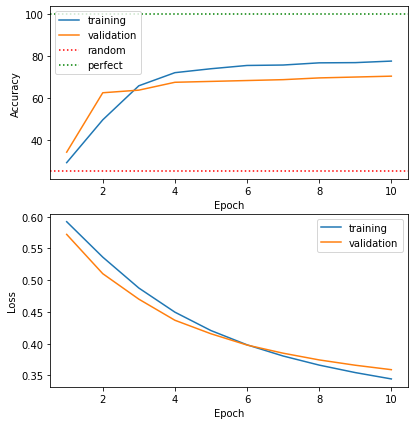

In [17]:
plot_learning_curve(learning_curve)

In [18]:
# In this cell we set a slower learning rate, but leave everything else the same as above
# Everything needed to experiment with batch size and learning rate is in this cell - try different values and see!
batch_size = 100
learning_rate = 1e-3
n_epochs = 10

num_workers=1
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

model = load_pretrained_model()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-3)
learning_curve = pd.DataFrame(index=range(n_epochs), columns=['train_loss', 'train_acc', 'val_loss', 'val_acc'])
since = time.time()
for epoch in range(n_epochs):
    print(f"=====Epoch {epoch+1}/{n_epochs}=====")
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, quiet=True)
    val_loss, val_acc = test(val_loader, model, loss_fn, quiet=True)
    learning_curve.loc[epoch] = (train_loss, train_acc, val_loss, val_acc)
    print(f"Cumulative time elapsed: {time.time() - since:.1f}")
total_training_time = time.time() - since
print(f"-------------------------------\nDone! Total time elapsed: {total_training_time:.1f}s")

Number of unfrozen layers: 1
=====Epoch 1/10=====
Train Accuracy: 24.5%, Avg loss: 0.634299
Test Accuracy: 27.9%, Avg loss: 0.568411
Cumulative time elapsed: 3.8
=====Epoch 2/10=====
Train Accuracy: 30.9%, Avg loss: 0.563443
Test Accuracy: 37.9%, Avg loss: 0.562087
Cumulative time elapsed: 7.6
=====Epoch 3/10=====
Train Accuracy: 38.8%, Avg loss: 0.558316
Test Accuracy: 41.7%, Avg loss: 0.546706
Cumulative time elapsed: 11.4
=====Epoch 4/10=====
Train Accuracy: 50.3%, Avg loss: 0.539669
Test Accuracy: 51.2%, Avg loss: 0.533436
Cumulative time elapsed: 15.5
=====Epoch 5/10=====
Train Accuracy: 58.9%, Avg loss: 0.529034
Test Accuracy: 56.7%, Avg loss: 0.523943
Cumulative time elapsed: 19.5
=====Epoch 6/10=====
Train Accuracy: 63.3%, Avg loss: 0.518612
Test Accuracy: 59.2%, Avg loss: 0.513813
Cumulative time elapsed: 23.5
=====Epoch 7/10=====
Train Accuracy: 66.4%, Avg loss: 0.508849
Test Accuracy: 63.8%, Avg loss: 0.504948
Cumulative time elapsed: 27.5
=====Epoch 8/10=====
Train Accuracy

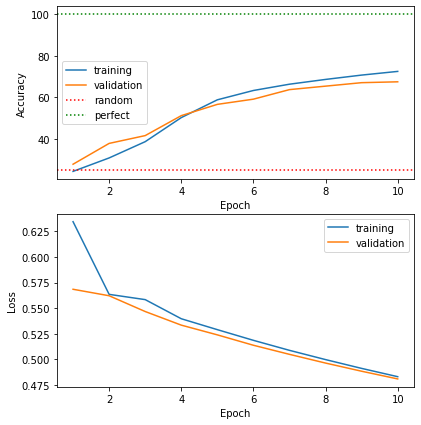

In [22]:
plot_learning_curve(learning_curve)

## Activity: Submit Result to Leaderboard

Experiment with the hyperparameters above, and see what validation accuracy you can get out of the model.
When you are happy with your model, run the following cell to submit your result to the leaderboard!

The leaderboard will track `batch_size` and `learning_rate`, but feel free to change other aspects of the model as well.

In [20]:
from datetime import datetime

user = os.environ['DOMINO_STARTING_USERNAME']
today_string = datetime.today().strftime('%Y%m%d')
my_results = {
    'user': user,
    'date': today_string,
    'accuracy': learning_curve['val_acc'].iloc[-1],
    'learning_rate': learning_rate,
    'batch_size': batch_size,
    'epochs': n_epochs,
    'training_time': total_training_time
}

my_results_file = f"{today_string}_{user}.csv"
my_results_path = os.path.join("results", my_results_file)
pd.DataFrame(my_results, index=[0,]).to_csv(my_results_path, index=False)
pd.read_csv(my_results_path).head()

,user,date,accuracy,learning_rate,batch_size,epochs,training_time
0,melanie-admin,20220823,67.5,0.001,100,10,39.532104


In [21]:
import boto3

client = boto3.client('s3', aws_access_key_id='', aws_secret_access_key='')
client._request_signer.sign = (lambda *args, **kwargs: None)

client.upload_file(my_results_path, "workshop-leaderboard", os.path.join("deep-learning", my_results_file))
print("Data uploaded succesfully")

Data uploaded succesfully
